# 4. Logistische Regression

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator, MultipleLocator

Eine alternative, besser an das Klassifikationsszenario angepasste Kostenfunktion statt des MSE ist die Kostenfunktion für die **logistische Regression**:

$C = - y \log(a^{L}) - (1 - y)\log(1 - a^{L})$.

Damit Sie diese in Ihrem Beispiel anwenden können, müssen Sie die Ableitung $\nabla_{a^{L}} C$ berechnen und die Funktion `cost_derivative()` entsprechend abändern. Da die logistische Regression davon ausgeht, dass der Output des Netzes eine Wahrscheinlichkeit zwischen 0 und 1 ist, können wir hierfür nicht den $\tanh()$ als Aktivierungsfunktion verwenden. Machen Sie daher Ihre Änderungen aus Aufgabe 3 rückgängig, so dass Sie wieder eine sigmoide
Aktivierungsfunktion haben. In der Funktion `evaluate()` sollte natürlich statt des MSE die Kostenfunktion der logistischen Regression ausgegeben werden, um zu überprüfen, ob tatsächlich ein Gradientenabstieg stattfindet. Weiterhin ist es nützlich, sowohl auf $C$ wie auf $\nabla_{a^{L}} C$ die Funktion `np.nan_to_num()` anzuwenden, da hier zuweilen numerische Probleme auftreten können. Auch die Lernrate muss angepasst werden: $\eta = 1.0$ funktioniert hier deutlich besser.

In [30]:
def logistic_regression(y, a, L):
    return np.nan_to_num(-y * np.log(a**L) - (1 - y) * np.log(1 - a**L))

# def logistic_regression_derivative(y, a, L):
#     return np.nan_to_num(- (y / (a**L)) + ((1 -y) / (1 - a**L)))

def cost_derivative(a_L, y):
    return np.nan_to_num(
        - (y / a_L) + ((1 - y) / (1 - a_L))
    )


In [31]:
# -------------------Initialisiere das Netz-------------------
mbs = 10
epochs = 150
lr = 0.3

sizes = [2, 2, 2, 1]
sizes_names = ['input', 'hidden1', 'hidden2', 'output']
num_layers = len(sizes)

# Fixed input neuron weights
w1 = np.array([0, 1])  # horizontal split
w2 = np.array([1, 0])  # vertical split

weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
biases = [np.random.randn(y, 1) for y in sizes[1:]]
for i, x in enumerate(weights):
    print(f"From {sizes_names[i]} → {sizes_names[i + 1]}:")
    print(x.shape)

From input → hidden1:
(2, 2)
From hidden1 → hidden2:
(2, 2)
From hidden2 → output:
(1, 2)


In [32]:
# Create labels (class 1 in quadrants 1 & 3, class 0 in quadrants 2 & 4)
def create_labels(X):
    y = np.zeros(X.shape[0])
    for i, (x1, x2) in enumerate(X):
        if np.sign(x1) == np.sign(x2):
            y[i] = 1
    return y

In [33]:
# ------------------Aus dem Vorlesungsbeispiel------------------
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

# Ableitung des Sigmoids
def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

def feedforward(a):
    """Return the output of the network if ``a`` is input."""
    for b, w in zip(biases, weights):
        a = sigmoid(np.dot(w, a)+b)
    return a

def backprop(x, y):
    """Return a tuple ``(nabla_b, nabla_w)`` representing the
    gradient for the cost function C_x.  ``nabla_b`` and
    ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
    to ``self.biases`` and ``self.weights``."""

    # Initialisiere Updates für Schwellwerte und Gewichte
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]

    # Vorwärtslauf
    activation = x # Initialisierung a^1 = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(biases, weights):
        z = np.dot(w, activation) + b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)

    # Rückwärtslauf
    delta = cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1]) # Fehler am Output
    nabla_b[-1] = delta # Update Schwellwert in der Ausgangsschicht
    nabla_w[-1] = np.dot(delta, activations[-2].transpose()) # Update Gewichte in der Ausgangsschicht
    for l in range(2, num_layers): # Backpropagation
        z = zs[-l] # gewichteter Input
        sp = sigmoid_prime(z) # Ableitung der Aktivierungsfunktion
        delta = np.dot(weights[-l+1].transpose(), delta) * sp # Fehler in Schicht l
        nabla_b[-l] = delta # Update Schwellwert
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose()) # Update Gewichte

    return (nabla_b, nabla_w)

def update_mini_batch(xmb, ymb, eta):
    """Update the network's weights and biases by applying
    gradient descent using backpropagation to a single mini batch.
    The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
    is the learning rate."""
    global weights
    global biases

    # Initialisiere Updates für Schwellwerte und Gewichte
    nabla_b = [np.zeros(b.shape) for b in biases]
    nabla_w = [np.zeros(w.shape) for w in weights]

    # Gehe durch alle Beispielpaare im Minibatch
    for i in range(xmb.shape[0]):
        x = np.reshape(xmb[i,:],(xmb.shape[1],1)).copy()
        if len(ymb.shape) == 2:
            y = np.reshape(ymb[i,:],(ymb.shape[1],1)).copy()
        else:
            y = ymb[i].copy()

        # Berechne Updates für alle Schichten über Backprop
        delta_nabla_b, delta_nabla_w = backprop(x, y)

        # Addiere einzelne Updates auf
        nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]

    # Berechne neue Gewichte
    weights = [w-(eta/xmb.shape[0])*nw
                    for w, nw in zip(weights, nabla_w)]
    biases = [b-(eta/xmb.shape[0])*nb
                   for b, nb in zip(biases, nabla_b)]

    return (weights, biases)

def evaluate(x2, y2):
    """Return the number of test inputs for which the neural
    network outputs the correct result. Note that the neural
    network's output is assumed to be the index of whichever
    neuron in the final layer has the highest activation."""

    correct = 0 # Anzahl korrekt klassifizierter Testbeispiele
    cost_derivatives = []

    # Gehe den Testdatensatz durch
    for i in range(0, x2.shape[0]):
        x = np.reshape(x2[i,:],(x2.shape[1],1)).copy()
        y = y2[i] # Klasse 0 oder Klasse 1

        # Vorwärtslauf
        ypred = feedforward(x).flatten()[0]

        cost_derivatives.append(cost_derivative(ypred, y))

        # Output < 0.5  → Klasse 0
        # Output ≥ 0.5 → Klasse 1
        pred_class = 1 if ypred > 0.5 else 0

        if pred_class == y:
            correct += 1

    return correct, np.array(cost_derivatives)

def SGD(x0, y0, epochs, mini_batch_size, eta, x2, y2):

    n_test = x2.shape[0] # Anzahl Testdaten
    n = x0.shape[0]      # Anzahl Trainingsdaten

    # gehe durch alle Epochen
    acc_val = np.zeros(epochs)
    cost_derivatives = np.zeros(epochs)
    for j in range(epochs):

        # Bringe die Trainingsdaten in eine zufällige Reihenfolge für jede Epoche
        p = np.random.permutation(n) # Zufällige Permutation aller Indizes von 0 .. n-1
        x0 = x0[p,:]
        y0 = y0[p]

        # Zerlege den permutierten Datensatz in Minibatches
        for k in range(0, n, mini_batch_size):
            xmb = x0[k:k+mini_batch_size,:]
            if len(y0.shape) == 2:
                ymb = y0[k:k+mini_batch_size,:]
            else:
                ymb = y0[k:k+mini_batch_size]
            update_mini_batch(xmb, ymb, eta)

        # Gib Performance aus
        evaluated = evaluate(x2, y2)
        acc_val[j] = evaluated[0]
        cost_derivatives[j] = np.mean(evaluated[1])
        # print("Epoch {0}: {1} / {2}".format(j, acc_val[j], n_test))

    return acc_val, cost_derivatives

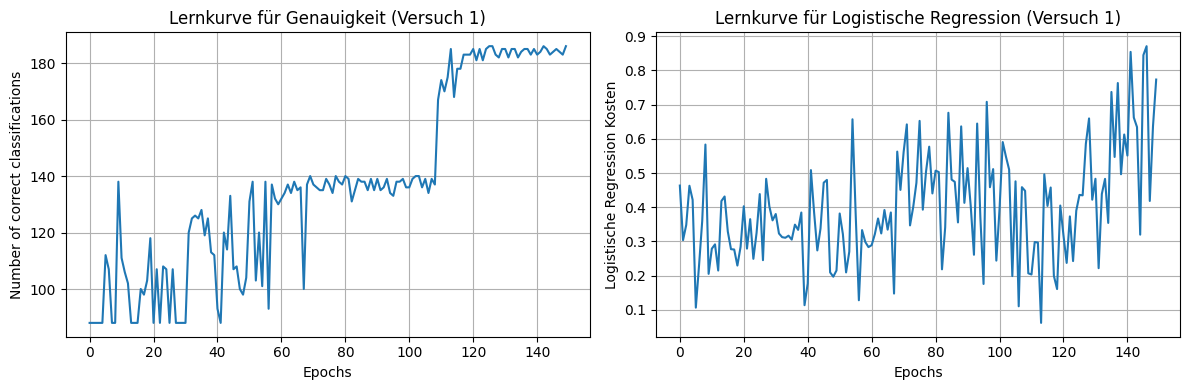

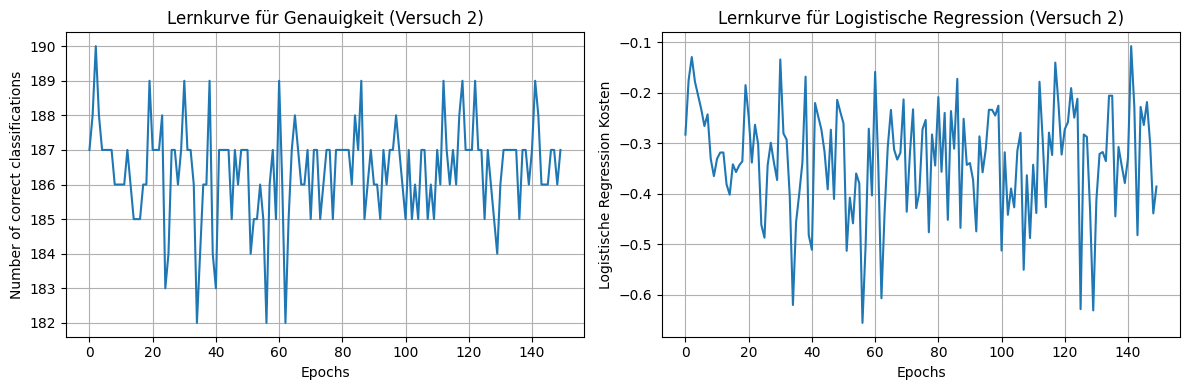

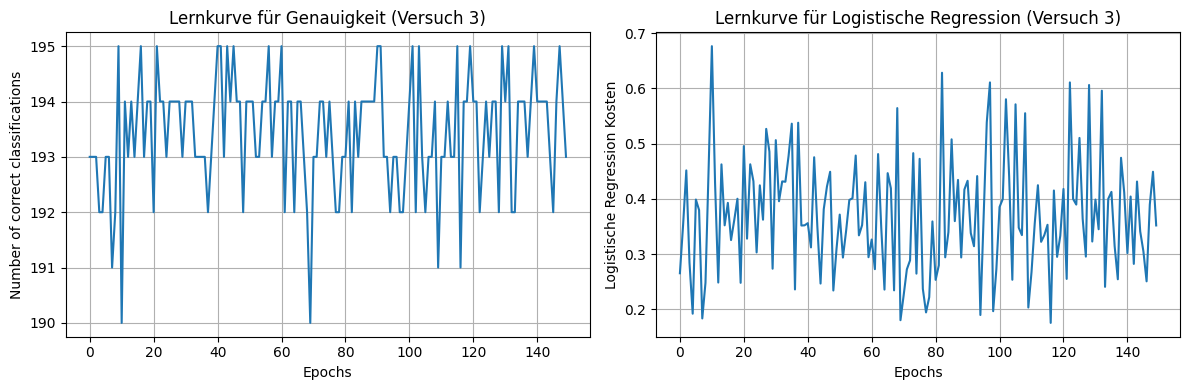

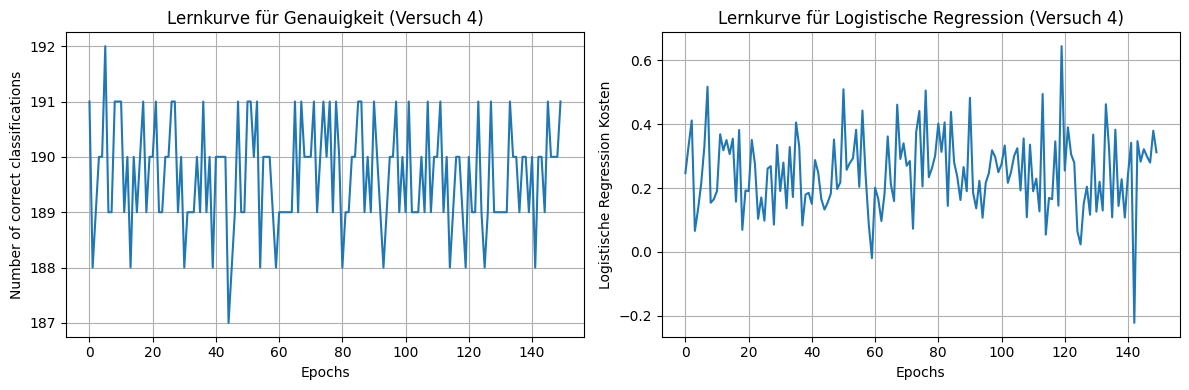

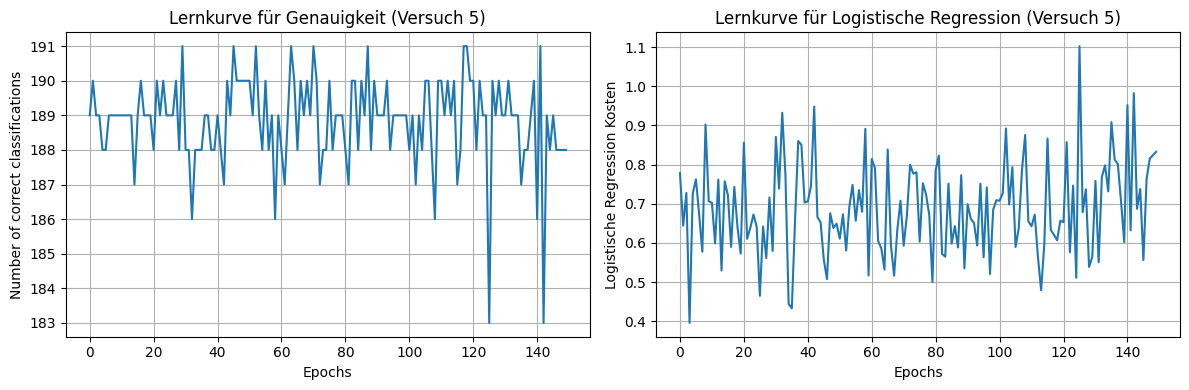

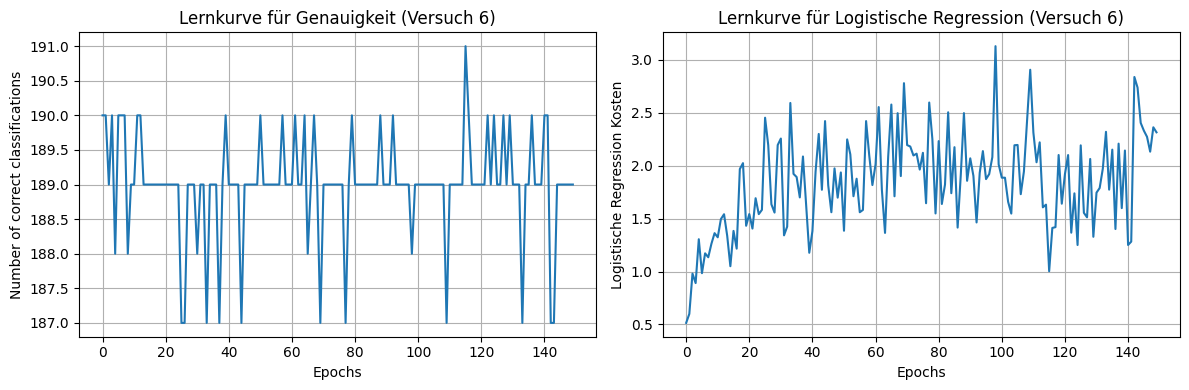

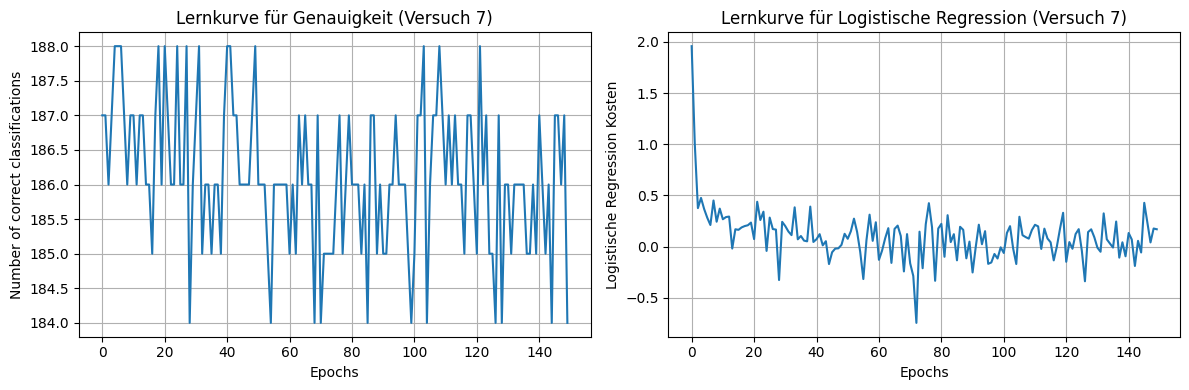

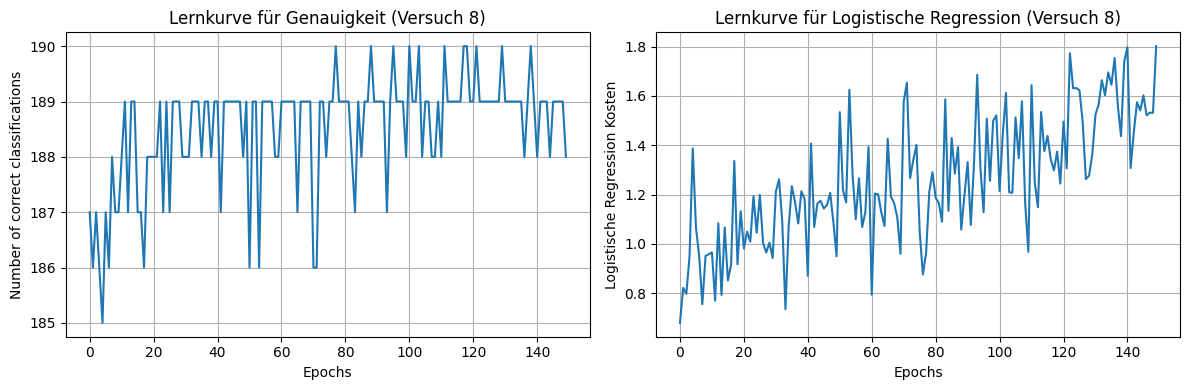

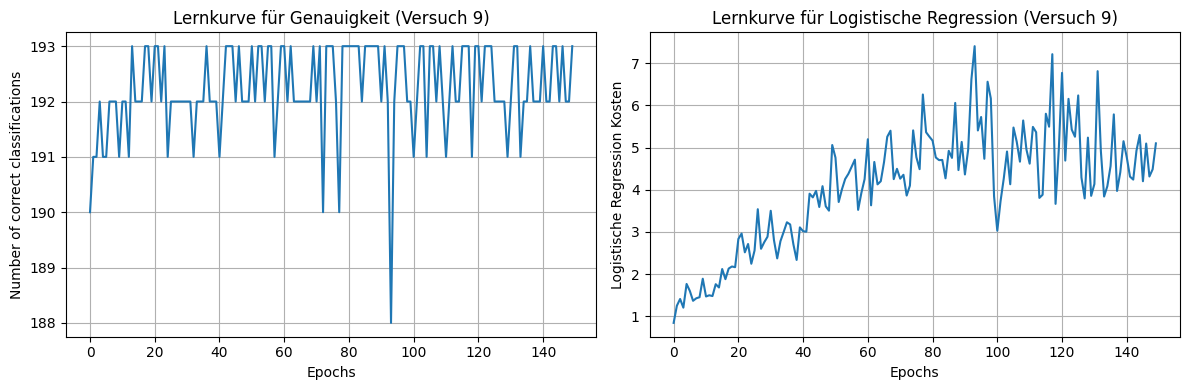

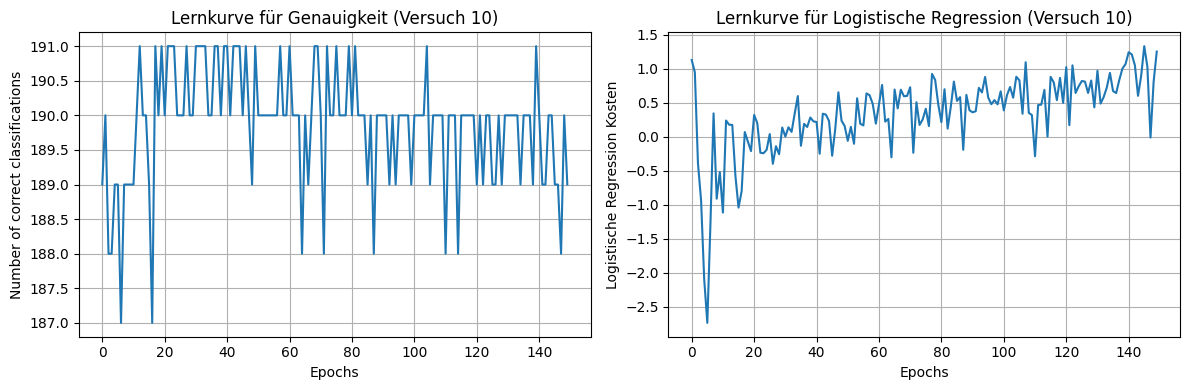

In [34]:
repeat_experiment = 10
all_trains = np.zeros(repeat_experiment, dtype=tuple)
for i in range(repeat_experiment):
    # ----------------- Prepare random seeded data ------------------
    # Generate training data
    np.random.seed(11 + i)
    X_train = np.random.uniform(low=-6, high=6, size=(200, 2))
    # Generate test data
    np.random.seed(22 + i)
    X_test = np.random.uniform(low=-6, high=6, size=(200, 2))
    y_train = create_labels(X_train)

    all_trains[i] = (X_train, y_train)

    y_test = create_labels(X_test)
    x0 = np.column_stack([
        sigmoid(w1[0] * X_train[:, 0] + w1[1] * X_train[:, 1]),
        sigmoid(w2[0] * X_train[:, 0] + w2[1] * X_train[:, 1])
    ])
    x1 = np.column_stack([
        sigmoid(w1[0] * X_test[:, 0] + w1[1] * X_test[:, 1]),
        sigmoid(w2[0] * X_test[:, 0] + w2[1] * X_test[:, 1])
    ])
    y0 = y_train
    y1 = y_test
    x2 = x1
    y2 = y1

    # ----------------- Train MLP ------------------
    acc_val, loss = SGD(x0, y0, epochs, mbs, lr, x2, y2)

    # ----------------- Plot learning curves ------------------
    x_plt = np.arange(0, epochs)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(x_plt, acc_val)
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Number of correct classifications')
    axes[0].grid()
    axes[0].set_title(f'Lernkurve für Genauigkeit (Versuch {i + 1})')

    axes[1].plot(x_plt, loss)
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Logistische Regression Kosten')
    axes[1].grid()
    axes[1].set_title(f'Lernkurve für Logistische Regression (Versuch {i + 1})')

    plt.tight_layout()
    plt.show()

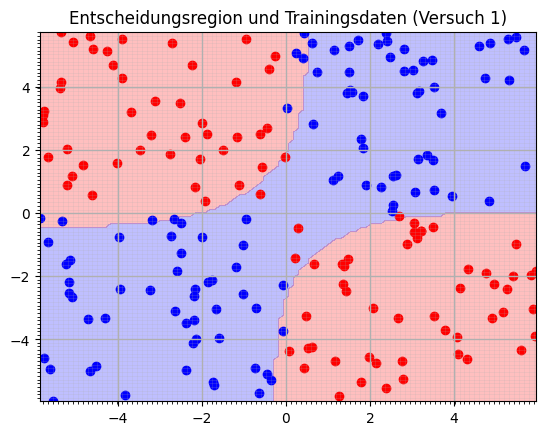

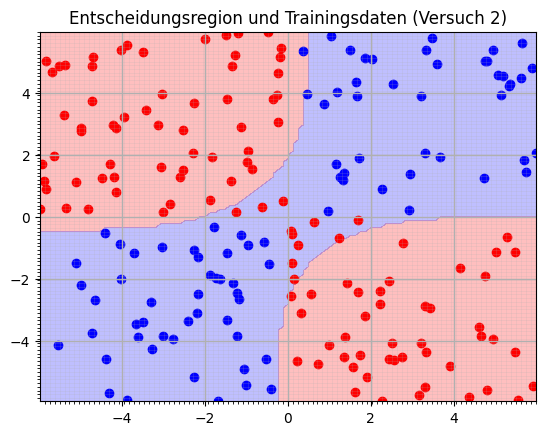

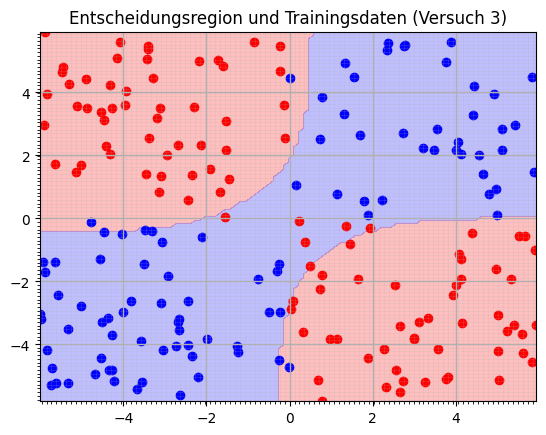

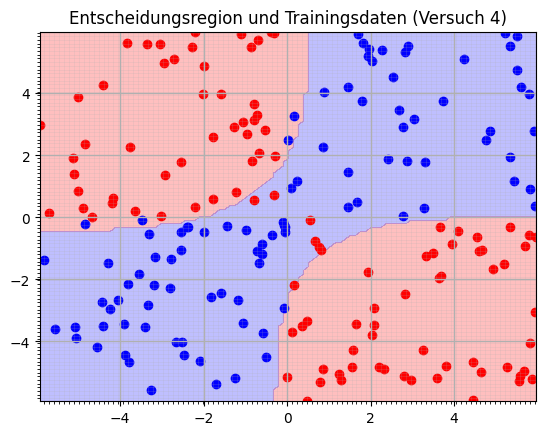

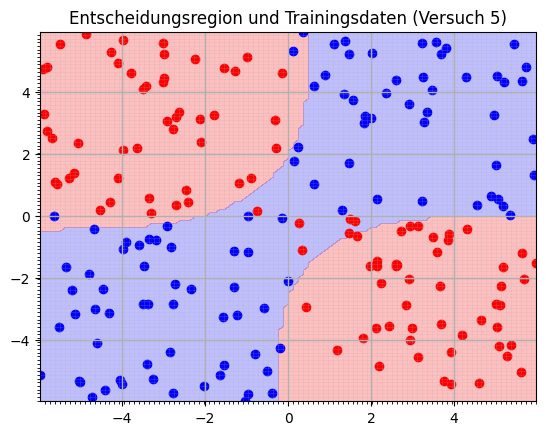

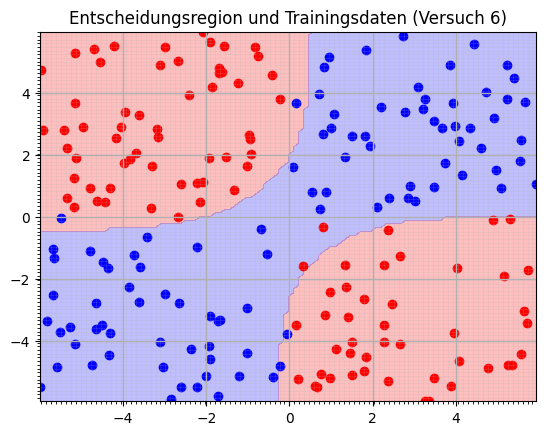

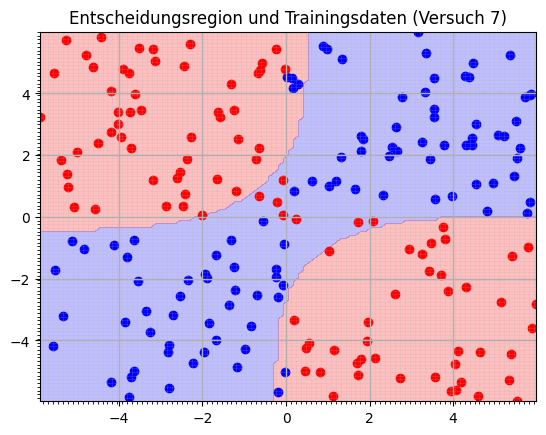

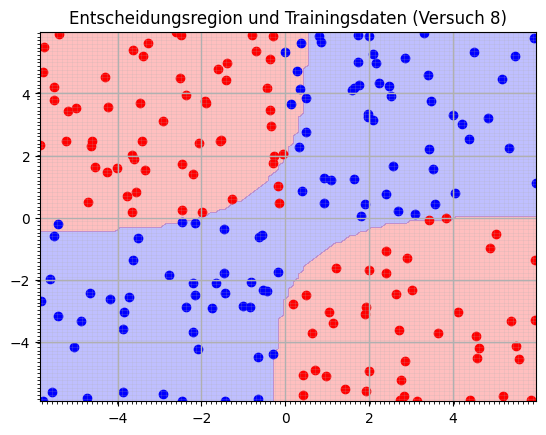

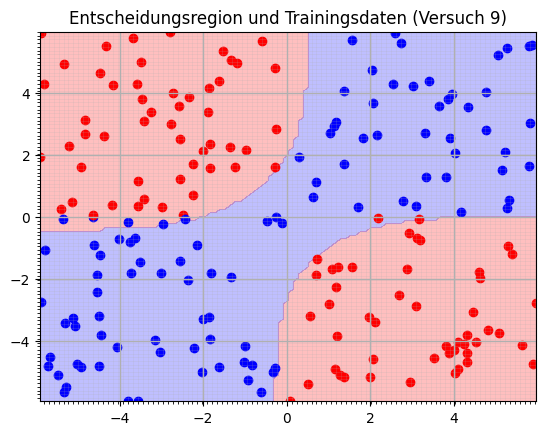

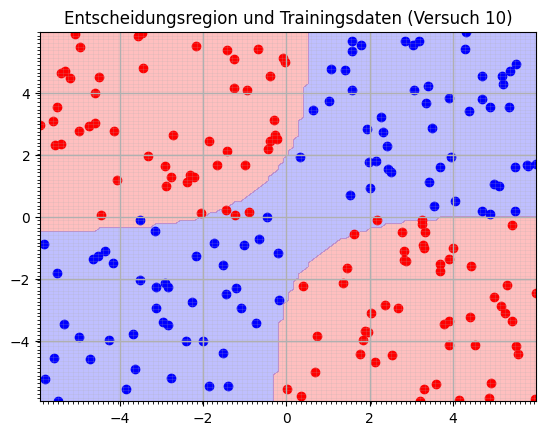

In [35]:
for k, (X_train, y_train) in enumerate(all_trains):
    min_x1 = np.min(X_train[:,0])
    max_x1 = np.max(X_train[:,0])
    min_x2 = np.min(X_train[:,1])
    max_x2 = np.max(X_train[:,1])

    fig, ax = plt.subplots()

    # --- Entscheidungsregion -----------------

    xx, yy = np.meshgrid(
        np.linspace(min_x1, max_x1, 100),
        np.linspace(min_x2, max_x2, 100)
    )

    Z = np.zeros(xx.shape)

    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            x1 = xx[i, j]
            x2 = yy[i, j]

            # dieselbe Vorverarbeitung wie beim Training:
            z1 = sigmoid(w1[0] * x1 + w1[1] * x2)  # = sigmoid(x2)
            z2 = sigmoid(w2[0] * x1 + w2[1] * x2)  # = sigmoid(x1)

            a0 = np.array([[z1],
                           [z2]])   # Input fürs MLP

            ypred = feedforward(a0).flatten()[0] # Entscheidungsfunktion
            Z[i, j] = ypred

    Z_cls = (Z > 0.5).astype(int)
    ax.contourf(xx, yy, Z_cls,
                levels=[-0.5, 0.5, 1.5],
                colors=["red", "blue"],
                alpha=0.25)

    # --- Trainingsdatenpunkte -----------------

    for x, y in zip(X_train, y_train):
        if y == 0:
            ax.scatter(x[0], x[1], color="red")
        else:
            ax.scatter(x[0], x[1], color="blue")

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    ax.xaxis.set_minor_locator(MultipleLocator((max_x1 - min_x1) / 100))
    ax.yaxis.set_minor_locator(MultipleLocator((max_x2 - min_x2) / 100))

    ax.grid(which="major", linewidth=1.0)
    ax.grid(which="minor", linewidth=0.4, alpha=0.3)

    plt.title(f'Entscheidungsregion und Trainingsdaten (Versuch {k + 1})')
    plt.show()